In [19]:
install.packages("ggplot2")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [20]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("scater", version = "3.8")
BiocManager::install("scran", version = "3.8")

Bioconductor version 3.8 (BiocManager 1.30.4), R 3.5.1 (2018-07-02)
Installing package(s) 'scater'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Update old packages: 'backports', 'BiocManager', 'bookdown', 'callr',
  'circlize', 'clipr', 'curl', 'data.table', 'ddalpha', 'digest', 'doParallel',
  'e1071', 'earth', 'ellipsis', 'foreach', 'foreign', 'geometry',
  'GlobalOptions', 'haven', 'hexbin', 'hms', 'htmltools', 'htmlwidgets',
  'httpuv', 'httr', 'igraph', 'iterators', 'kernlab', 'KernSmooth', 'knitr',
  'lambda.r', 'later', 'lava', 'lpSolve', 'markdown', 'Matrix', 'matrixStats',
  'mgcv', 'modelr', 'nlme', 'openssl', 'pkgconfig', 'plotmo', 'pls', 'prodlim',
  'promises', 'purrr', 'R6', 'Rcpp', 'RcppAnnoy', 'RcppArmadillo', 'RcppEigen',
  'recipes', 'reticulate', 'Rhdf5lib', 'rlang', 'rmarkdown', 'RSpectra',
  'RSQLite', 'rvest', 'scales', 'selectr', 'shiny', 'survival', 'sys',
  'testthat', 'tidyr', 'tidyverse', 'tinytex', 'TTR', 'umap', 'whisker',
 

In [21]:
suppressWarnings(suppressPackageStartupMessages(library(ggthemes)))
suppressWarnings(suppressPackageStartupMessages(library(cowplot)))
suppressWarnings(suppressPackageStartupMessages(library(scran)))
suppressWarnings(suppressPackageStartupMessages(library(ggplot2)))

In [22]:
sce = readRDS("/hps/nobackup/hipsci/scratch/singlecell_endodiff/data_processed/merged/20180618/sce_merged_afterqc_filt_allexpts.rds")

In [23]:
## HVGs (highly variable genes)
sce = normalize(sce)
design = model.matrix(~ experiment, data = colData(sce))
alt.fit = trendVar(sce, design = design, use.spikes = FALSE)
alt.decomp = decomposeVar(sce, alt.fit)

Warning message in .get_all_sf_sets(object):
“spike-in set 'ERCC' should have its own size factors”

In [24]:
top.500hvgs = rownames(alt.decomp[order(alt.decomp$bio, decreasing = TRUE),])[1:500]
rowData(sce)$is_intop500hvg <- (rownames(sce) %in% top.500hvgs)
pca.500hvgs = prcomp(t(logcounts(sce[rowData(sce)$is_intop500hvg,])))$x
sce$PC1_top500hvgs = pca.500hvgs[,1]
# some cells will not be assigned to any stage
sce$stage = "not assigned"
# just assign all day0 cells to ips
sce[,sce$day == "day0"]$stage = "ips"
# still based on not scale PC1, since those are the criteria used for eQTLs
sce[,sce$PC1_top500hvgs  > -23 & sce$PC1_top500hvgs < 4 & sce$day %in% c("day1","day2")]$stage = "mesendo"
sce[,sce$PC1_top500hvgs  > 22 & sce$day %in% c("day2","day3")]$stage = "defendo"
sce$pseudotime = sce$PC1_top500hvgs

In [25]:
# select genes to be plotted

In [26]:
diff_genes_reduced = c("ENSG00000111704_NANOG", "ENSG00000164458_T", "ENSG00000163508_EOMES", "ENSG00000141448_GATA6")

In [27]:
s = sce$pseudotime
range01 <- function(x){(x-min(x))/(max(x)-min(x))}
df = data.frame(cell = sce$cell_name, day = sce$day, expt = sce$experiment, donor = sce$donor) 
df$pseudo = range01(s)
head(df)

cell,day,expt,donor,pseudo
<chr>,<chr>,<chr>,<chr>,<dbl>
21843_1#10,day1,expt_09,joxm,0.3022399
21843_1#100,day1,expt_09,fafq,0.5042794
21843_1#101,day1,expt_09,fafq,0.4352490
21843_1#102,day1,expt_09,wuye,0.2695033
21843_1#103,day1,expt_09,joxm,0.3735655
21843_1#105,day1,expt_09,iisa,0.4149124


In [28]:
plist = list()
for (i in 1:length(diff_genes_reduced)){
    gene = diff_genes_reduced[i]
    df$gene = logcounts(sce)[gene,]
    plist[[i]] = ggplot(df, aes(x = as.numeric(pseudo), y = as.numeric(gene), colour = as.factor(day))) + 
            geom_point(alpha = 0.2, pch = 20) 
}

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


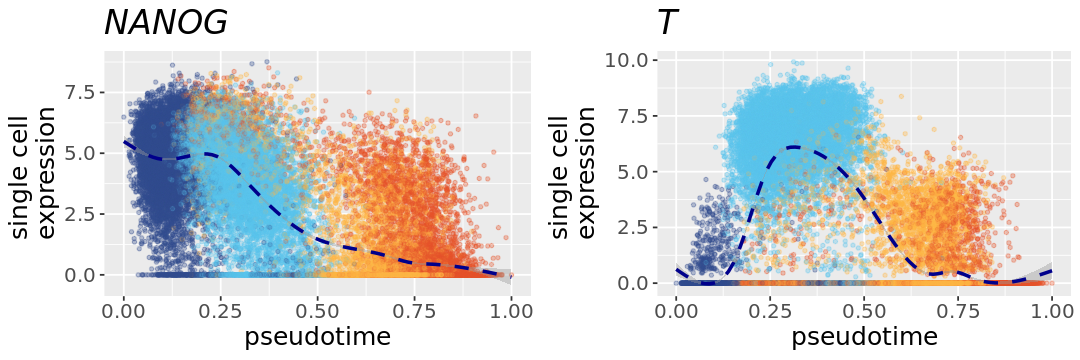

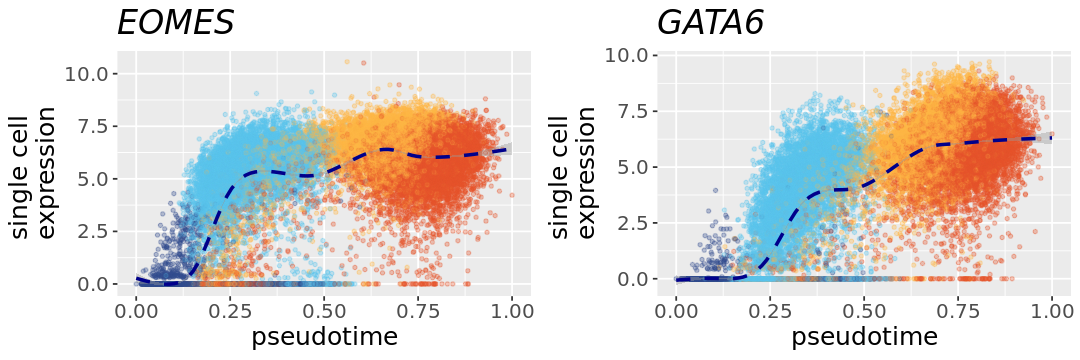

In [29]:
options(repr.plot.width = 9, repr.plot.height = 3) 
plist = plist
for (j in seq(2, length(diff_genes_reduced), by = 2)){
    p1 = plist[[j-1]]
    p1 = p1 + ggtitle(gsub(".*_","",diff_genes_reduced[j-1])) + 
         xlab("pseudotime") + ylab("single cell \nexpression") + labs(colour = "day") + 
        scale_color_canva(palette = "Pool party") + geom_point(alpha = 0.15, pch = 20) +
        stat_smooth(colour = "darkblue", linetype = 2) +  
        theme(legend.position="none", panel.border = element_blank(), text = element_text(size = 15))+
        theme(plot.title = element_text(face = "italic", size = 20))
    p2 = plist[[j]]
    p2 = p2 + ggtitle(gsub(".*_","",diff_genes_reduced[j])) + 
        xlab("pseudotime") + ylab("single cell \nexpression") + labs(colour = "day") + 
        scale_color_canva(palette = "Pool party") + geom_point(alpha = 0.15, pch = 20) +
        stat_smooth(colour = "darkblue", linetype = 2) + 
        theme(legend.position="none", panel.border = element_blank(), text = element_text(size = 15)) +
        theme(plot.title = element_text(face = "italic", size = 20))
    print(plot_grid(p1, p2, ncol = 2))
}

In [5]:
s = sce$PC1_top500hvgs
range01 <- function(x){(x-min(x))/(max(x)-min(x))}
df = data.frame(cell = sce$cell_name, day = sce$day, expt = sce$experiment, donor = sce$donor) 
df$pseudo = range01(s)

In [14]:
library(ggplot2)
library(ggthemes)

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


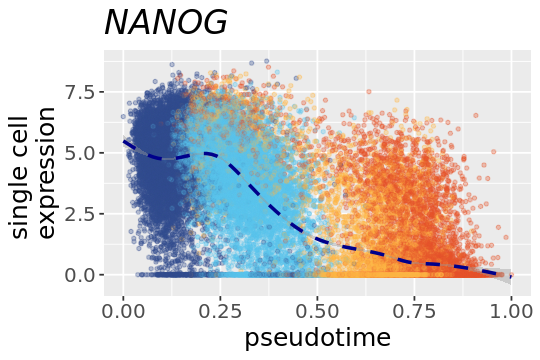

In [15]:
i = 1
gene = diff_genes_reduced[i]
df$gene = logcounts(sce)[gene,]
p = ggplot(df, aes(x = as.numeric(pseudo), y = as.numeric(gene), colour = as.factor(day))) + 
            geom_point(alpha = 0.2, pch = 20) 
options(repr.plot.width = 4.5, repr.plot.height = 3) 
p + ggtitle(gsub(".*_","",diff_genes_reduced[i])) + 
         xlab("pseudotime") + ylab("single cell \nexpression") + labs(colour = "day") + 
        scale_color_canva(palette = "Pool party") + geom_point(alpha = 0.15, pch = 20) +
        stat_smooth(colour = "darkblue", linetype = 2) +  
        theme(legend.position="none", panel.border = element_blank(), text = element_text(size = 15))+
        theme(plot.title = element_text(face = "italic", size = 20))

In [17]:
plist = list()
for (i in 1:length(diff_genes_reduced)){
    gene = diff_genes_reduced[i]
    df$gene = logcounts(sce)[gene,]
    plist[[i]] = ggplot(df, aes(x = as.numeric(pseudo), y = as.numeric(gene), colour = as.factor(day))) + 
            geom_point(alpha = 0.2, pch = 20) 
}

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'
`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


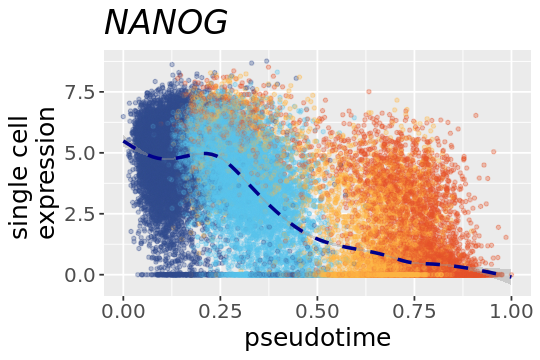

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


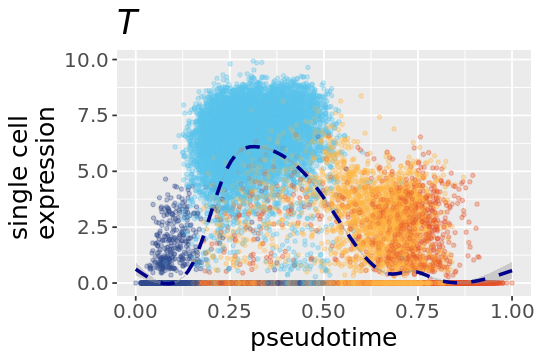

`geom_smooth()` using method = 'gam' and formula 'y ~ s(x, bs = "cs")'


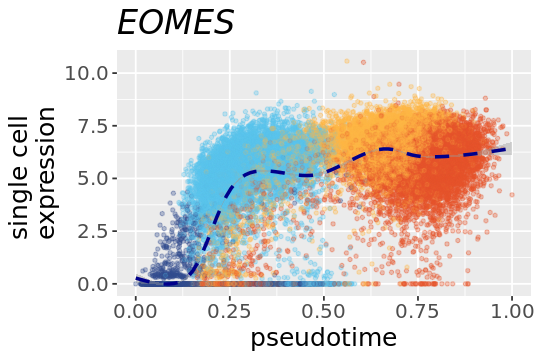

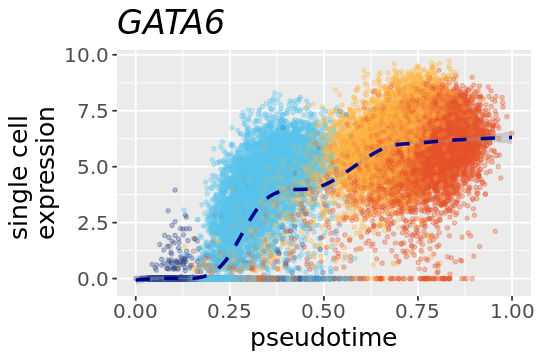

In [18]:
options(repr.plot.width = 4.5, repr.plot.height = 3) 
plist = plist
for (j in 1:length(diff_genes_reduced)){
    p2 = plist[[j]]
    p2 = p2 + ggtitle(gsub(".*_","",diff_genes_reduced[j])) + 
        xlab("pseudotime") + ylab("single cell \nexpression") + labs(colour = "day") + 
        scale_color_canva(palette = "Pool party") + geom_point(alpha = 0.15, pch = 20) +
        stat_smooth(colour = "darkblue", linetype = 2) + 
        theme(legend.position="none", panel.border = element_blank(), text = element_text(size = 15)) +
        theme(plot.title = element_text(face = "italic", size = 20))
    print(p2)
}

In [ ]:
svg(filename="/hps/nobackup/stegle/users/acuomo/all_scripts/sc_endodiff/main_figures/figure1D_NANOG_bis.svg", 
    width=4.5, 
    height=3, 
    pointsize=12)
p1
dev.off()